# Amazon Review Analysis Based on Beauty Products: Sentiment, Textual Features, and Product Quality

This notebook analyzes Amazon consumer reviews from multiple product categories to explore how textual feedback correlates with perceived product quality. We use transformer-based models (BERT) for sentence embeddings and regression analysis to evaluate rating deviations.

## Project Scope: Beauty Product Reviews

This project focuses on customer reviews of beauty products from Amazon. We analyze how review text reflects perceived product quality through sentiment analysis, rating deviation modeling, and regression using transformer-based embeddings.

In [72]:
# Neccessary Libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from wordcloud import WordCloud
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge

## Exploratory Data Analysis (EDA)

Before modeling, we explore basic properties of the dataset to understand rating distributions, review lengths, and patterns across categories. 


In [3]:
# Load raw review data
dataset_beauty = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
print(dataset_beauty["full"][0])

{'rating': 5.0, 'title': 'Such a lovely scent but not overpowering.', 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", 'images': [], 'asin': 'B00YQ6X8EO', 'parent_asin': 'B00YQ6X8EO', 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ', 'timestamp': 1588687728923, 'helpful_vote': 0, 'verified_purchase': True}


In [5]:
# Convert the full split to a DataFrame
df_beauty = dataset_beauty['full'].to_pandas()
df_beauty.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [7]:
df_beauty = df_beauty[['asin', 'rating', 'title', 'text', 'helpful_vote', 'verified_purchase']]
df_beauty['text'] = df_beauty['text'].astype(str)
df_beauty['review_length'] = df_beauty['text'].apply(lambda x: len(x.split()))

In [9]:
sample = df_beauty.iloc[0]
print(f"Rating: {sample['rating']}")
print(f"Title: {sample['title']}")
print(f"Text: {sample['text']}")

Rating: 5.0
Title: Such a lovely scent but not overpowering.
Text: This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!


/var/folders/35/481h5z3934x7111xbgyyz4540000gn/T/ipykernel_14366/3795453360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_beauty, x="verified_purchase", y="rating", palette="coolwarm")


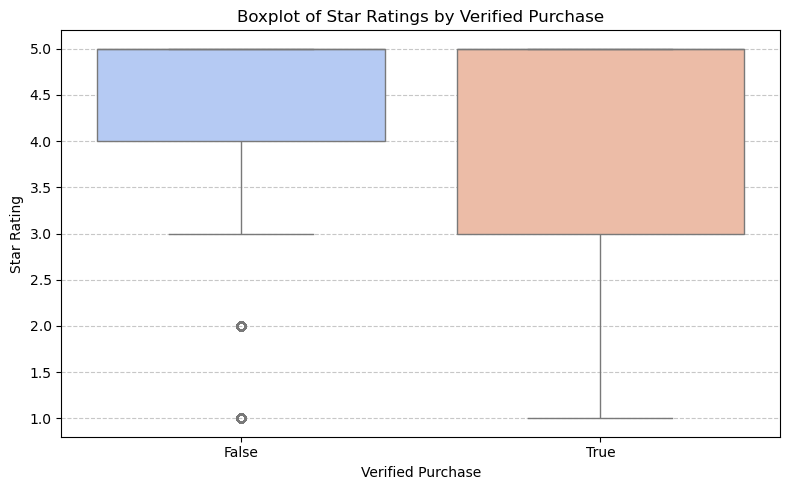

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_beauty, x="verified_purchase", y="rating", palette="coolwarm")
plt.title("Boxplot of Star Ratings by Verified Purchase")
plt.xlabel("Verified Purchase")
plt.ylabel("Star Rating")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("rating_boxplot_verified.png")
plt.show()

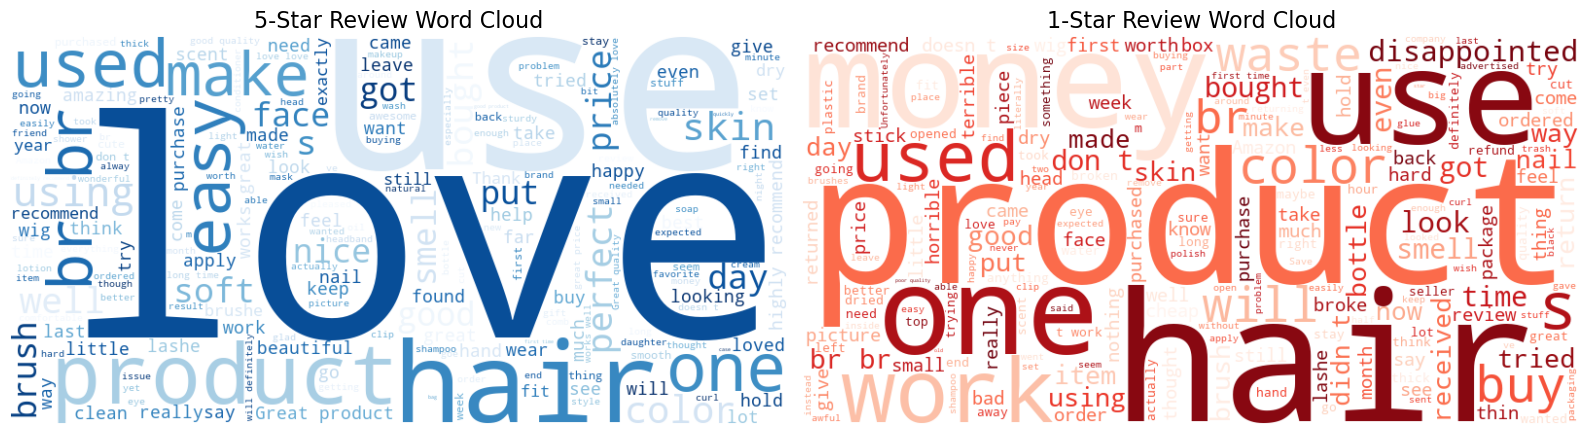

In [13]:
# Filter 5-star and 1-star reviews
five_star_reviews = df_beauty[df_beauty["rating"] == 5.0]["text"].dropna().astype(str)
one_star_reviews = df_beauty[df_beauty["rating"] == 1.0]["text"].dropna().astype(str)

# Join text
five_star_text = " ".join(five_star_reviews.tolist())
one_star_text = " ".join(one_star_reviews.tolist())

# Generate WordClouds
wc_five = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(five_star_text)
wc_one = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(one_star_text)

# Plot side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_five, interpolation='bilinear')
plt.axis("off")
plt.title("5-Star Review Word Cloud", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wc_one, interpolation='bilinear')
plt.axis("off")
plt.title("1-Star Review Word Cloud", fontsize=16)

plt.tight_layout()
plt.savefig("wordcloud_comparison.png")
plt.show()

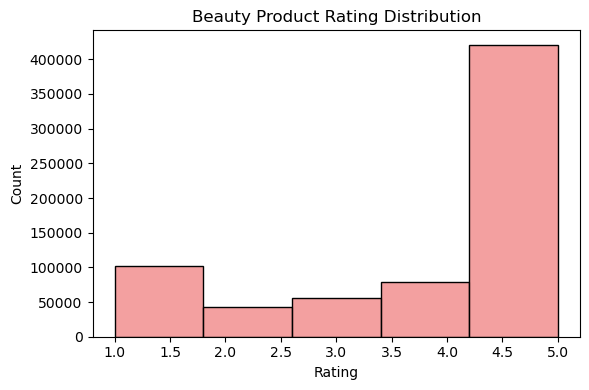

In [15]:
# Ratings
plt.figure(figsize=(6, 4))
sns.histplot(df_beauty['rating'], bins=5, color='lightcoral')
plt.title("Beauty Product Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

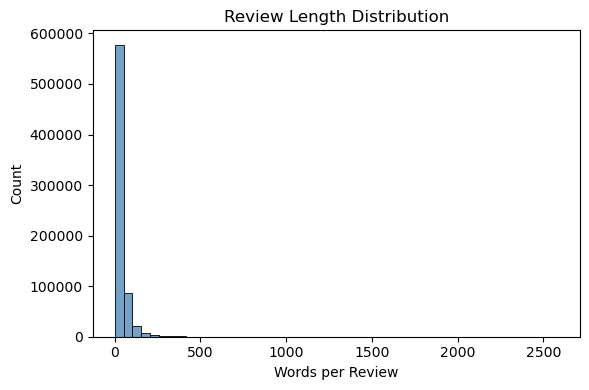

In [17]:
# Review length
plt.figure(figsize=(6, 4))
sns.histplot(df_beauty['review_length'], bins=50, color='steelblue')
plt.title("Review Length Distribution")
plt.xlabel("Words per Review")
plt.tight_layout()
plt.show()

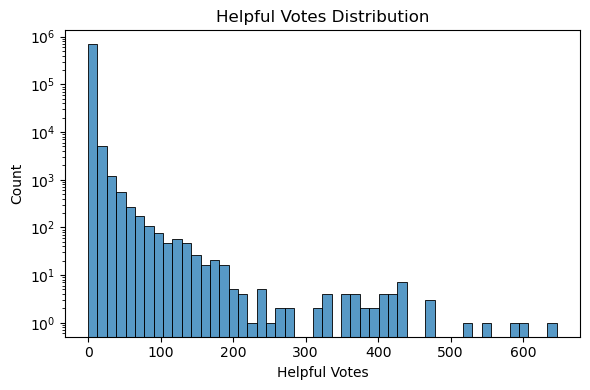

In [19]:
# Helpful votes
plt.figure(figsize=(6, 4))
sns.histplot(df_beauty['helpful_vote'], bins=50)
plt.title("Helpful Votes Distribution")
plt.xlabel("Helpful Votes")
plt.yscale("log")
plt.tight_layout()
plt.show()

## Merge with Product Metadata

We merge each review with its corresponding product's average rating (from metadata) to calculate rating deviation — the difference between a user's rating and the average rating of the product.


In [22]:
print("Merging with metadata...")
meta_beauty = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True).to_pandas()
meta_beauty = meta_beauty[['parent_asin', 'average_rating']].dropna()

df_merge = pd.merge(df_beauty, meta_beauty, left_on='asin', right_on='parent_asin', how='left').dropna()
df_merge['rating_deviation'] = df_merge['rating'] - df_merge['average_rating']
df_merge = df_merge[df_merge['text'].str.len() > 20].reset_index(drop=True)

df_merge.head()

Merging with metadata...


,asin,rating,title,text,helpful_vote,verified_purchase,review_length,parent_asin,average_rating,rating_deviation
0,B00YQ6X8EO,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,0,True,61,B00YQ6X8EO,4.3,0.7
1,B081TJ8YS3,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",1,True,47,B081TJ8YS3,4.0,0.0
2,B00R8DXL44,4.0,Pretty Color,The polish was quiet thick and did not apply s...,0,True,24,B00R8DXL44,3.8,0.2
3,B099DRHW5V,5.0,Handy,Great for many tasks. I purchased these for m...,0,True,22,B099DRHW5V,3.5,1.5
4,B08P2DZB4X,5.0,Great for at home use and so easy to use!,This is perfect for my between salon visits. I...,0,False,72,B08P2DZB4X,3.8,1.2


## Generate BERT Embeddings for Review Text

We use `sentence-transformers` to generate dense vector representations of each review. These embeddings capture semantic meaning for use in downstream modeling.


In [53]:
df_sample = df_merge.sample(10000, random_state=42).reset_index(drop=True)

print("Generating BERT embeddings for 10,000 reviews...")
model_bert = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model_bert.encode(df_sample['text'].tolist(), batch_size=32, show_progress_bar=True)

Generating BERT embeddings for 10,000 reviews...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

## Fit Linear Regression to Predict Rating Deviation

We use the BERT embeddings as input features to predict rating deviation using a simple linear regression model.


In [56]:
print("Fitting regression model...")
X = np.array(embeddings)
y = df_sample['rating_deviation'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("Regression R² score with BERT embeddings:", r2)

Fitting regression model...
Regression R² score with BERT embeddings: 0.3540727775143434


### Visualize Predictions
A scatterplot of predicted vs. actual values to see how well the model fit.

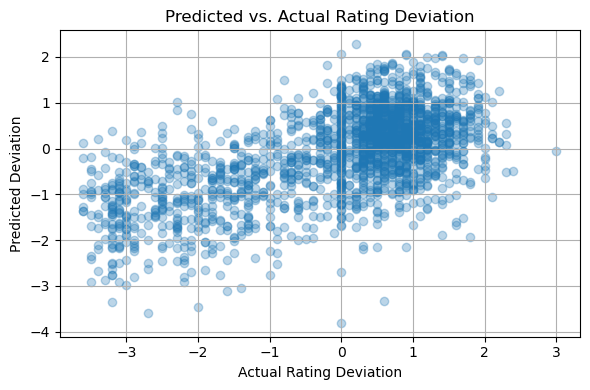

In [59]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Rating Deviation")
plt.ylabel("Predicted Deviation")
plt.title("Predicted vs. Actual Rating Deviation")
plt.grid(True)
plt.tight_layout()
plt.show()

### Error Analysis
Check examples where the model was most wrong.

In [62]:
df_sample['prediction'] = reg.predict(X)
df_sample['abs_error'] = np.abs(df_sample['prediction'] - df_sample['rating_deviation'])

# Top 5 highest error reviews
df_sample.sort_values('abs_error', ascending=False)[['text', 'rating', 'prediction', 'rating_deviation', 'abs_error']].head()

,text,rating,prediction,rating_deviation,abs_error
9145,Still trying it but not see too much effect,5.0,-2.403677,2.3,4.703677
9019,"I couldn't closed it, so didn’t work.<br />—->...",4.0,-3.335464,0.6,3.935464
9808,Waste of money. Very useless product.,1.0,-3.806041,0.0,3.806041
1890,This hair ties were very useful as elastic for...,1.0,0.200914,-3.6,3.800914
9826,"very ackward to use/hold, perhaps a little to ...",1.0,0.749705,-3.0,3.749705


### Compare Verified vs. Unverified Reviews
We check if verified reviews are more consistent with average product rating.

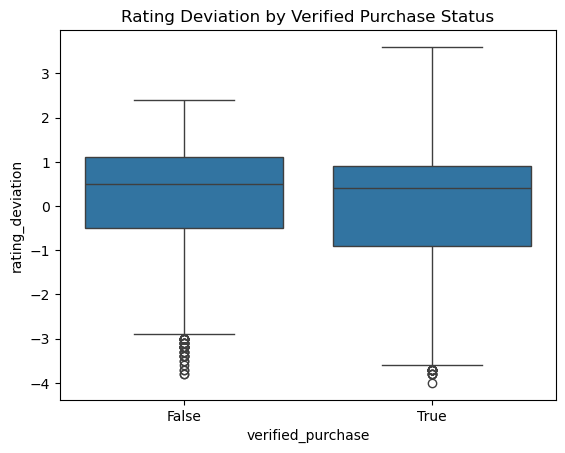

In [65]:
sns.boxplot(data=df_sample, x='verified_purchase', y='rating_deviation')
plt.title("Rating Deviation by Verified Purchase Status")
plt.show()

#  Lasso Regression on BERT Embeddings

In [68]:
X = np.array(embeddings)
y = df_sample['rating_deviation'].values

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Lasso
lasso = Lasso(alpha=0.1)  # Try alpha=0.01, 0.1, 1.0 as needed
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Lasso Regression R² score:", r2)
print("Lasso RMSE:", rmse)

Lasso Regression R² score: -0.0007740937169409268
Lasso RMSE: 1.391047602757293


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Lasso yielded a negative R^2 value (-0.0008), suggesting that it underfit the data by overly penalizing model complexity.

# Ridge Regression on BERT Embeddings

In [75]:
ridge = Ridge(alpha=1.0)  
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# Evaluation
print("Ridge Regression R^2 score:", r2_score(y_test, y_pred))
print("Ridge RMSE:", mean_squared_error(y_test, y_pred, squared=False))

Ridge Regression R^2 score: 0.38200516346511026
Ridge RMSE: 1.093116344738257


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge regression delivered the best performance, achieving an R^2 score of 0.382 and RMSE of 1.093. This suggests that BERT-derived semantic features explain over one-third of the variation in rating deviation, validating their relevance to perceived product quality. 